<b>1. Подготовка данных</b>

1.1. Извлечение кадров из видео
Для начала были скачаны видео с блюдами ресторана(\yolo-test\data\raw_videos). Далее произведено разбиение видео на последовательность кадров с определённой частотой(\yolo-test\data\frames)

Использовалась библиотека cv2 (OpenCV) для чтения видео

Кадры сохранялись с именами, содержащими порядковый номер и timestamp

Пропуск кадров позволил уменьшить избыточность и размер выборки

In [1]:
import cv2
import os

base_path = os.getcwd()

# Папки с видео и кадрами
input_dir = os.path.join(base_path, "data", "raw_videos")
output_dir = os.path.join(base_path, "data", "frames")

video_files = [f for f in os.listdir(input_dir) if f.lower().endswith(".mov")]

# Проверка наличия видеофайлов
if not video_files:
    print("В папке raw_videos нет файлов с расширением .MOV")
else:
    print(f"Найдено {len(video_files)} видео: {video_files}")

frame_rate = 2  # Сколько кадров в секунду сохраняем (2 кадра/сек)

# Обработка каждого видео
for video_file in video_files:
    video_path = os.path.join(input_dir, video_file)
    name = os.path.splitext(video_file)[0]
    save_path = os.path.join(output_dir, name)
    os.makedirs(save_path, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0 or fps is None:
        print(f"Не удалось прочитать FPS для {video_file}, пропускаем.")
        continue

    step = int(fps // frame_rate)

    count = 0
    saved = 0
    success, frame = cap.read()

    print(f"\n Обрабатываем {video_file} (FPS: {fps})")

    while success:
        if count % step == 0:
            filename = os.path.join(save_path, f"frame_{saved:04d}.jpg")
            cv2.imwrite(filename, frame)
            saved += 1
        success, frame = cap.read()
        count += 1

    cap.release()
    print(f"Сохранено {saved} кадров из {video_file}")

Текущий путь: C:\Users\PC\Desktop\yolo-test
Найдено 6 видео: ['1.MOV', '2_1.MOV', '3_1.MOV', '3_2.MOV', '4.MOV', '4_1.MOV']

Обрабатываем 1.MOV (FPS: 30.0)
Сохранено 12 кадров из 1.MOV

Обрабатываем 2_1.MOV (FPS: 30.0020299073009)
Сохранено 99 кадров из 2_1.MOV

Обрабатываем 3_1.MOV (FPS: 30.00201491033649)
Сохранено 199 кадров из 3_1.MOV

Обрабатываем 3_2.MOV (FPS: 30.001733202380265)
Сохранено 116 кадров из 3_2.MOV

Обрабатываем 4.MOV (FPS: 30.002085409087748)
Сохранено 144 кадров из 4.MOV

Обрабатываем 4_1.MOV (FPS: 30.00296179287195)
Сохранено 68 кадров из 4_1.MOV


<b>Вывод:</b>
Извлечение прошло успешно, удалось создать набор изображений для последующей аннотации.

<b>1.2 Разметка и аугментация</b>

<div style="white-space: pre-wrap;">Разметку проводил вручную, на сайте roboflow, аугментацию делал там же. 
Аннотированы bounding box'ы с классами блюд:
tea
shashlik
greek_salad
lamb
borscht
caesar_salad
cheese_soup
    
Вот параметры аугментации, которые я выбрал:
Outputs per training example: 3
Flip: Horizontal, Vertical
Rotation: Between -15° and +15°
Saturation: Between -25% and +25%
Brightness: Between -20% and +20%
Noise: Up to 1.05% of pixels
Разделение данных: train/val/test с соотношением 88/8/4
Также ссылка на датасет: https://app.roboflow.com/derawer/dishes-mo66n/1
</div>

<b>2. Обучение модели YOLOv11 (первая итерация)</b>
<div style="white-space: pre-wrap;"><b>2.1. Настройка модели</b>
Модель YOLOv11 была обучена на подготовленном датасете. Использовалась следующая конфигурация:

Количество эпох: 50
Базовая модель: yolov11n.pt
Batch size: 16
Размер изображения: 640x640</div>

In [1]:
from ultralytics import YOLO

model = YOLO('C:/Users/PC/Desktop/yolo-test/yolo11n.pt')

results = model.train(
    data='C:/Users/PC/Desktop/yolo-test/dataset/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    project='runs',
    name='yolov11-dish',
    save_period=10
)

Ultralytics 8.3.161  Python-3.9.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/PC/Desktop/yolo-test/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=C:/Users/PC/Desktop/yolo-test/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp17, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas

train: Scanning C:\Users\PC\Desktop\yolo-test\dataset\train\labels.cache...


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.20.1 ms, read: 9.10.7 MB/s, size: 71.2 KB)


val: Scanning C:\Users\PC\Desktop\yolo-test\dataset\valid\labels.cache... 1


Plotting labels to yolov11-dish\exp17\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolov11-dish\exp17
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.28G      1.263      2.612      1.284        124        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.989      0.448      0.875      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.79G      1.027      1.007      1.127         93        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.967      0.977      0.985      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.79G     0.8987     0.8307      1.079        106        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.991      0.991      0.991      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.79G     0.8672     0.7557      1.047         56        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.988      0.992      0.992      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.79G     0.7924     0.6934      1.028         90        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571       0.99      0.989      0.991      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.79G     0.7319     0.6179      1.004         98        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.973      0.986      0.989      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.79G     0.7333     0.5838      1.005        104        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571       0.99      0.993      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.79G     0.6731     0.5485     0.9869         86        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.988      0.993      0.991      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.8G     0.6698     0.5106     0.9809        102        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.989      0.988      0.991      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.8G     0.6385     0.4918     0.9726        107        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.989       0.99      0.991      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.8G      0.646     0.4839      0.976         94        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.991      0.991       0.99      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.8G     0.6424     0.4616     0.9715         95        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571       0.99      0.992      0.991      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.8G     0.6064     0.4378     0.9588         97        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.992      0.991      0.992      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.8G     0.5963     0.4288     0.9572        100        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.992       0.99      0.993      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.8G     0.5994     0.4165     0.9542         86        6
                 Class     Images  Instances      Box(P          R      mAP


                   all        127        571       0.99       0.99      0.992      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.8G     0.5932     0.4129     0.9574         98        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.989      0.992      0.993       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.8G     0.5686     0.3921     0.9457         81        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.987      0.993      0.993      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.8G     0.5652     0.3911     0.9489         79        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.989      0.993      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.8G     0.5548     0.3845     0.9507         76        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.992      0.991      0.991      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.8G      0.542     0.3701     0.9434        111        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.989      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.8G     0.5236     0.3628     0.9366        122        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.992      0.993      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.8G      0.527     0.3574      0.933        133        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.991      0.989      0.993      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.8G     0.5068     0.3441     0.9302         92        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.994      0.993      0.992       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.8G       0.51     0.3518     0.9323        102        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.991      0.995      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.8G     0.5004      0.337     0.9274         86        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.996      0.992      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.8G     0.4905     0.3282     0.9258        111        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.994      0.992      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.8G     0.4959      0.332      0.927         98        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.992      0.996      0.993      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.8G     0.4726     0.3143     0.9214         81        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.994      0.992      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.8G     0.4785     0.3186     0.9186        107        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.991      0.996      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.8G     0.4779     0.3228     0.9264         90        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.996      0.993      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.8G      0.467     0.3074     0.9166         84        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.992      0.996      0.993      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.8G     0.4554     0.3027     0.9183        105        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.995      0.991      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.8G     0.4617     0.3056     0.9203         78        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.992      0.996      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.8G     0.4549     0.3041     0.9153         94        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.992      0.996      0.993      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.8G     0.4426     0.2939     0.9088         99        6
                 Class     Images  Instances      Box(P          R      mAP


                   all        127        571      0.993      0.996      0.993      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.8G       0.44     0.2944     0.9138        102        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.995      0.994      0.994       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.8G     0.4309     0.2865     0.9059         78        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.997      0.993      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.8G     0.4258     0.2834     0.9019         71        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.994      0.995      0.993      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.8G     0.4291     0.2824     0.9055         62        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.995      0.994      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.8G     0.4115     0.2717     0.8994        108        6
                 Class     Images  Instances      Box(P          R      mAP


                   all        127        571      0.992      0.996      0.994      0.925
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.8G     0.3621     0.2303      0.878         72        6
                 Class     Images  Instances      Box(P          R      mAP


                   all        127        571      0.994      0.996      0.994      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.8G     0.3541     0.2234     0.8663         54        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.996      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.8G     0.3462     0.2179      0.873         58        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.994      0.995      0.994      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.8G     0.3382     0.2149     0.8704         51        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.994      0.994      0.994      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.8G     0.3354     0.2113     0.8617         50        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.992      0.996      0.993      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.8G     0.3193     0.2047      0.866         59        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.995      0.994      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.8G      0.315     0.1998     0.8574         58        6
                 Class     Images  Instances      Box(P          R      mAP


                   all        127        571      0.993      0.996      0.994      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.8G       0.31      0.195     0.8582         52        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.996      0.994      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.8G     0.3012     0.1905     0.8521         50        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.996      0.994       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.8G     0.3021     0.1919      0.855         53        6
                 Class     Images  Instances      Box(P          R      mAP

                   all        127        571      0.993      0.996      0.994      0.931



50 epochs completed in 0.184 hours.
Optimizer stripped from yolov11-dish\exp17\weights\last.pt, 5.5MB
Optimizer stripped from yolov11-dish\exp17\weights\best.pt, 5.5MB

Validating yolov11-dish\exp17\weights\best.pt...
Ultralytics 8.3.161  Python-3.9.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP


                   all        127        571      0.993      0.996      0.994      0.931
               borscht         52         52      0.981      0.979       0.99      0.906
          caesar_salad         55         55      0.995          1      0.995      0.954
           cheese_soup         45         45      0.995          1      0.995      0.853
           greek_salad         55         55      0.995          1      0.995      0.966
                  lamb        118        118       0.99          1      0.995      0.931
              shashlik        119        119          1      0.993      0.995      0.956
                   tea        127        127      0.998          1      0.995       0.95
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to yolov11-dish\exp17


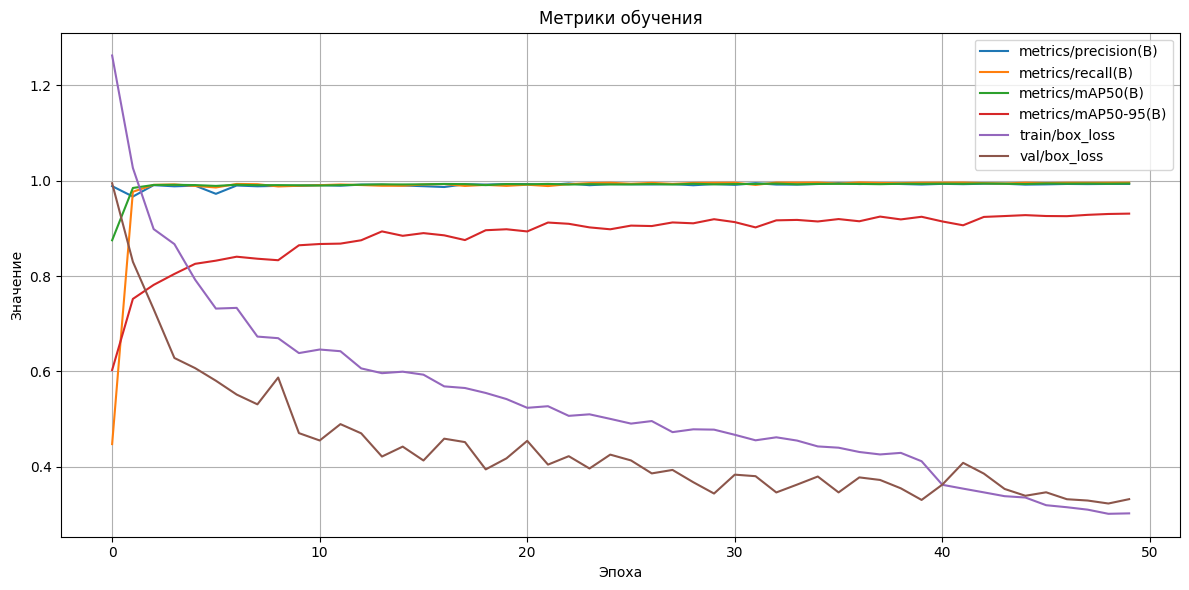

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Путь к файлу с логами
csv_path = "C:/Users/PC/Desktop/yolo-test/yolov11-dish/results_v1.csv"
df = pd.read_csv(csv_path)

# Графики
metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'train/box_loss', 'val/box_loss']
df[metrics].plot(figsize=(12, 6), grid=True)
plt.title("Метрики обучения")
plt.xlabel("Эпоха")
plt.ylabel("Значение")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()


<div style="white-space: pre-wrap;"><b>2.2. Результаты первой модели</b>
По графикам видно, что средние метрики:
Precision:  0.9910
Recall:  0.9821
mAP@0.5:  0.9902
mAP@0.5:0.95:  0.8858
Val box loss:  0.4415</div>

<div style="white-space: pre-wrap;">Улучшения:
lr0  - 0.002 - Уменьшить шаг, тк модель уже обучилась
epochs - 30 - Уменшить кол-во эпох, для дообучения достаточно 30
optimizer - SGD - Для плавности</div>

In [4]:
from ultralytics import YOLO

model = YOLO("C:/Users/PC/Desktop/yolo-test/yolov11-dish/exp17/weights/best_v1.pt")  # дообучаем на лучших весах

model.train(
    data='C:/Users/PC/Desktop/yolo-test/dataset/data.yaml',
    epochs=30,
    imgsz=640,
    batch=16,
    lr0=0.002,
    optimizer='SGD',
    project='runs',
    name='yolov11-dish_v2',
    save_period=5
)

Ultralytics 8.3.161  Python-3.9.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/PC/Desktop/yolo-test/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=C:/Users/PC/Desktop/yolo-test/yolov11-dish/exp17/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11-dish_v22, nbs=64, nms=False, opset=None, optimize=F

train: Scanning C:\Users\PC\Desktop\yolo-test\dataset\train\labels.cache... 1341 images, 21 backgrounds, 0 corrupt: 100


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.20.1 ms, read: 6.11.5 MB/s, size: 71.2 KB)


val: Scanning C:\Users\PC\Desktop\yolo-test\dataset\valid\labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██


Plotting labels to runs\yolov11-dish_v22\labels.jpg... 
optimizer: SGD(lr=0.002, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\yolov11-dish_v22
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.27G     0.3965     0.2682     0.8988        119        640: 100%|██████████| 84/84 [00:17<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<0

                   all        127        571      0.994      0.996      0.994      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.79G     0.4073     0.2703     0.8949        105        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994      0.996      0.994      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.79G     0.4057     0.2806     0.8909        108        640: 100%|██████████| 84/84 [00:13<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994      0.996      0.994      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.79G     0.4066     0.2845     0.8929         98        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.995      0.994      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.79G     0.4008     0.2841     0.8942        123        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994      0.996      0.994      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.79G      0.403     0.2763     0.8922        111        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.995      0.994      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.79G     0.4033      0.269     0.8909         66        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0


                   all        127        571      0.993      0.996      0.994      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.79G     0.3995     0.2711     0.8929         82        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.996      0.993      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.79G      0.409     0.2789     0.8975        105        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.993      0.996      0.994      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.79G     0.3967     0.2665     0.9002        108        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.993      0.996      0.994      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.79G      0.404     0.2676      0.895         99        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994      0.996      0.994      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.79G     0.3919      0.265     0.8926        129        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994      0.996      0.994      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.79G     0.3851     0.2606     0.8908         85        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.993      0.997      0.994      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.79G      0.391      0.262     0.8923         95        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.992      0.994      0.994       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.79G     0.3795      0.254     0.8923         88        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.987      0.994      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.79G     0.3825     0.2543     0.8902        114        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.992      0.997      0.994      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.79G     0.3768      0.256     0.8953         59        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994       0.99      0.994       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.79G     0.3777     0.2495     0.8926         75        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.985      0.993      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.79G     0.3761     0.2503     0.8892        101        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995       0.99      0.994      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.79G     0.3657     0.2452     0.8868         86        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.993      0.996      0.994      0.936


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.79G     0.3084     0.1958     0.8559         54        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.993      0.997      0.993      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.79G     0.3078     0.1927     0.8566         62        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.996      0.994      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.79G     0.2976     0.1889      0.854         62        640: 100%|██████████| 84/84 [00:12<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994      0.996      0.994      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.79G      0.298     0.1865     0.8509         62        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.996      0.994      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.79G     0.2937     0.1855     0.8475         76        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994      0.996      0.994      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.79G     0.2892     0.1847     0.8466         68        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.994      0.996      0.994      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.79G     0.2887     0.1825     0.8447         58        640: 100%|██████████| 84/84 [00:11<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.996      0.994       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.79G     0.2845     0.1788     0.8491         60        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.996      0.994      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.79G     0.2817     0.1793     0.8452         58        640: 100%|██████████| 84/84 [00:11<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.996      0.994      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.79G     0.2795     0.1781      0.844         70        640: 100%|██████████| 84/84 [00:12<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        127        571      0.995      0.996      0.994      0.933



30 epochs completed in 0.120 hours.
Optimizer stripped from runs\yolov11-dish_v22\weights\last.pt, 5.5MB
Optimizer stripped from runs\yolov11-dish_v22\weights\best.pt, 5.5MB

Validating runs\yolov11-dish_v22\weights\best.pt...
Ultralytics 8.3.161  Python-3.9.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<0


                   all        127        571      0.993      0.996      0.994      0.936
               borscht         52         52      0.976      0.981      0.987      0.917
          caesar_salad         55         55      0.995          1      0.995      0.958
           cheese_soup         45         45      0.995          1      0.995      0.882
           greek_salad         55         55      0.995          1      0.995       0.95
                  lamb        118        118      0.991          1      0.995      0.936
              shashlik        119        119          1      0.995      0.995      0.959
                   tea        127        127      0.998          1      0.995      0.949
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\yolov11-dish_v22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000249F0ED88B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

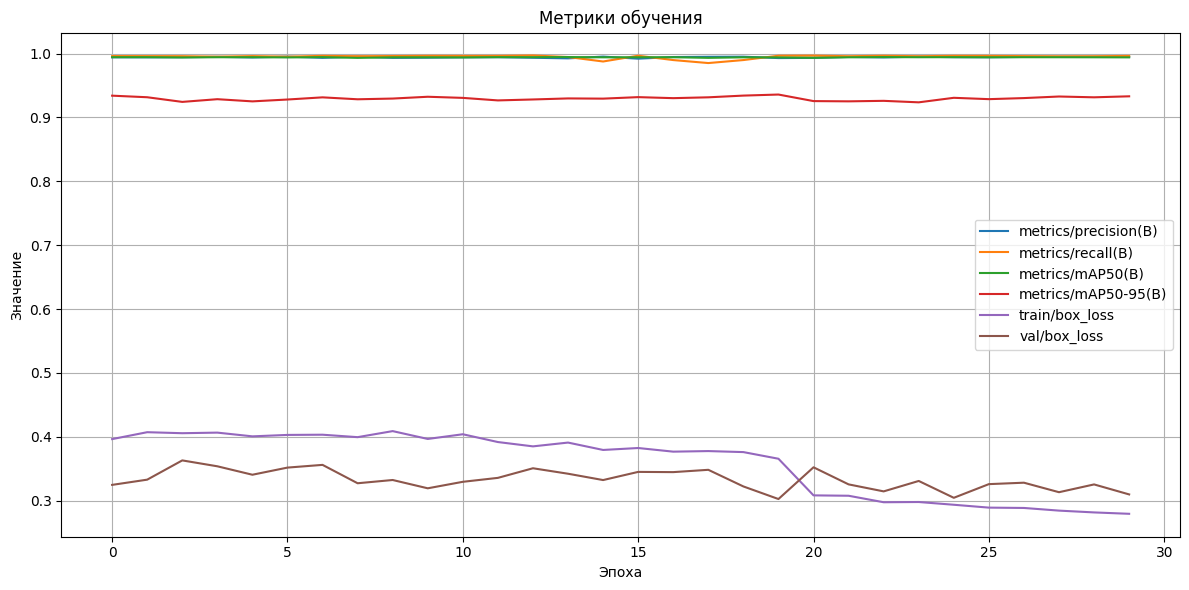

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Путь к файлу с логами
csv_path = "C:/Users/PC/Desktop/yolo-test/runs/yolov11-dish_v22/results_v2.csv"
df = pd.read_csv(csv_path)

# Графики
metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'train/box_loss', 'val/box_loss']
df[metrics].plot(figsize=(12, 6), grid=True)
plt.title("Метрики обучения")
plt.xlabel("Эпоха")
plt.ylabel("Значение")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()


<div style="white-space: pre-wrap;"><b>2.3. Результаты второй модели:</b>
Precision:  0.9941
Recall:  0.9949
mAP@0.5:  0.9940
mAP@0.5:0.95:  0.9296
Val box loss:  0.3329</div>

<b>3. Сравнение моделей</b>
| Метрика       | Модель 1  | Модель 2  |
| ------------- | --------------- | ----------------------- |
| Precision     | 0.9910          | 0.9941              |
| Recall        | 0.9821          | 0.9949              |
| mAP\@0.5      | 0.9902          | 0.9940              |
| mAP\@0.5:0.95 | 0.8858          | 0.9296              |
| Val box loss  | 0.4415          | 0.3329              |
            


<div style="white-space: pre-wrap;"><b>4. Финальный вывод по обучению</b>
4.1 Модель 2 показывает улучшение по всем основным метрикам благодаря оптимизации гиперпараметров (уменьшение batch, изменение lr, momentum и др.).
4.2 Метрики mAP и Recall выросли почти до предельных значений.
4.3 Улучшение mAP@0.5:0.95 указывает на то, что модель лучше обобщает на сложных случаях и разных масштабах объектов.
4.4 Снижение box loss демонстрирует, что модель научилась точнее локализовать объекты.

<b>Вывод: Вторая модель с оптимизированными параметрами однозначно превосходит первую и будет использоваться как финальная версия.</b></div>